<a href="https://colab.research.google.com/github/plerte/coursework1/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [210]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
seq_len = 64 #128

Tensorflow version: 2.4.1


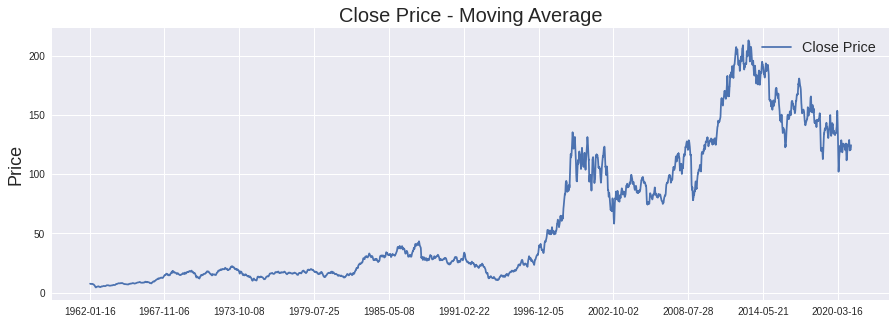

In [211]:
IBM_path = '/content/drive/MyDrive/coursework/shares_IBM.csv'
df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

df.head()
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

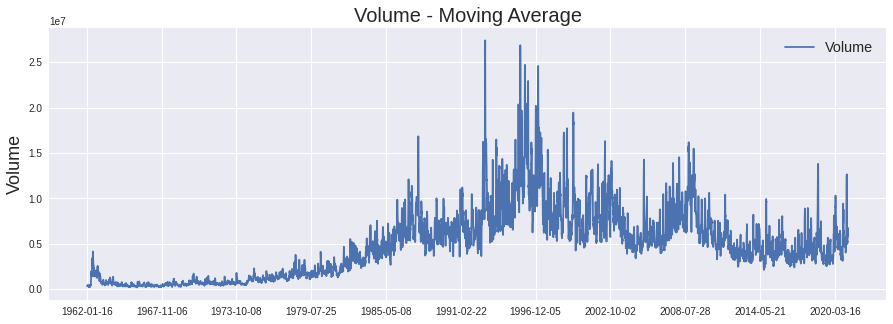

In [212]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume - Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

In [213]:
###############################################################################
'''Normalize price columns'''

df['Open'] = (df['Open']-np.mean(df['Open']))/np.std(df['Open'])
df['High'] = (df['High']-np.mean(df['High']))/np.std(df['High'])
df['Low'] = (df['Low']-np.mean(df['Low']))/np.std(df['Low']) 
df['Close'] = (df['Close']-np.mean(df['Close']))/np.std(df['Close'])
df['Volume'] = (df['Volume']-np.mean(df['Volume']))/np.std(df['Volume'])

df.head()

,Date,Open,High,Low,Close,Volume
9,1962-01-16,-0.934065,-0.935671,-0.932619,-0.934413,-1.187577
10,1962-01-17,-0.934390,-0.936108,-0.933134,-0.935005,-1.184230
11,1962-01-18,-0.934948,-0.936535,-0.933556,-0.935429,-1.181276
12,1962-01-19,-0.935355,-0.936904,-0.933837,-0.935580,-1.180291
13,1962-01-22,-0.935494,-0.936915,-0.933673,-0.935510,-1.187380


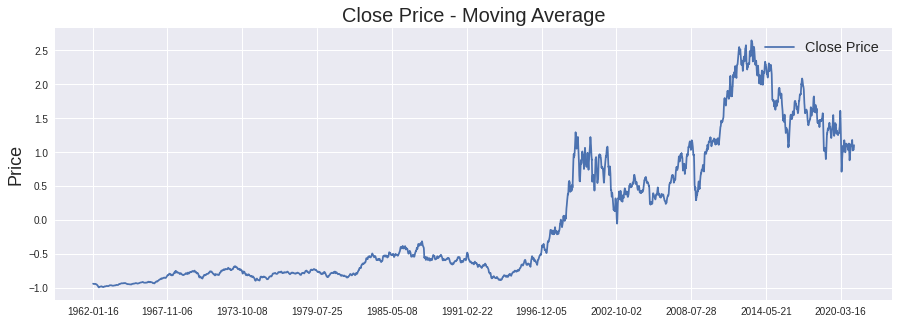

In [214]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

In [215]:
#ToDo переделать без сортировки
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

print('after sorting')
df.head()

after sorting


,Date,Open,High,Low,Close,Volume
9,1962-01-16,-0.934065,-0.935671,-0.932619,-0.934413,-1.187577
10,1962-01-17,-0.934390,-0.936108,-0.933134,-0.935005,-1.184230
11,1962-01-18,-0.934948,-0.936535,-0.933556,-0.935429,-1.181276
12,1962-01-19,-0.935355,-0.936904,-0.933837,-0.935580,-1.180291
13,1962-01-22,-0.935494,-0.936915,-0.933673,-0.935510,-1.187380


In [216]:
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (11914, 5)
Validation data shape: (1489, 5)
Test data shape: (1489, 5)


,Open,High,Low,Close,Volume
9,-0.934065,-0.935671,-0.932619,-0.934413,-1.187577
10,-0.934390,-0.936108,-0.933134,-0.935005,-1.184230
11,-0.934948,-0.936535,-0.933556,-0.935429,-1.181276
12,-0.935355,-0.936904,-0.933837,-0.935580,-1.180291
13,-0.935494,-0.936915,-0.933673,-0.935510,-1.187380


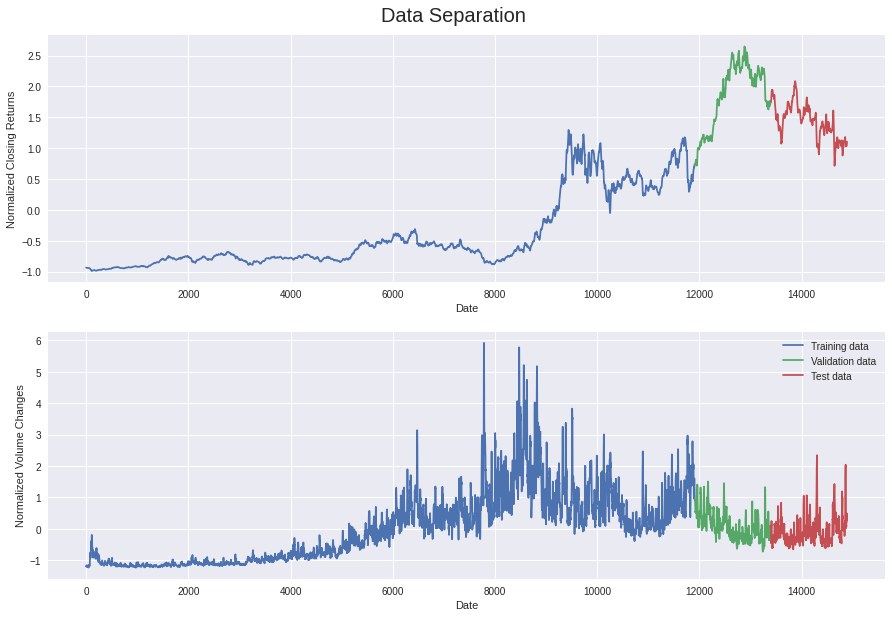

In [217]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

In [218]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11850, 64, 5) (11850,)
(1425, 64, 5) (1425,)


In [219]:
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(64, input_shape=(seq_len, 5), return_sequences=True))
  model.add(tf.keras.layers.LSTM(64,return_sequences=True))
  model.add(tf.keras.layers.LSTM(32))
  model.add(tf.keras.layers.Dense(1))#, activation=tf.nn.relu))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

In [220]:
model = create_model()

model.summary()

model.fit(X_train, y_train,
              batch_size=1024,
              epochs=30,
              validation_data=(X_val, y_val),)    

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 64, 64)            17920     
_________________________________________________________________
lstm_51 (LSTM)               (None, 64, 64)            33024     
_________________________________________________________________
lstm_52 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 63,393
Trainable params: 63,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
12/12 [==============================] - 6s 178ms/step - loss: 0.1805 - val_loss: 0.7430
Epoch 2/30
12/12 [==============================] - 1s 67ms/step - loss: 0.0164 - val_loss: 0.7702
Epoch 3/30
12/12 [==============================

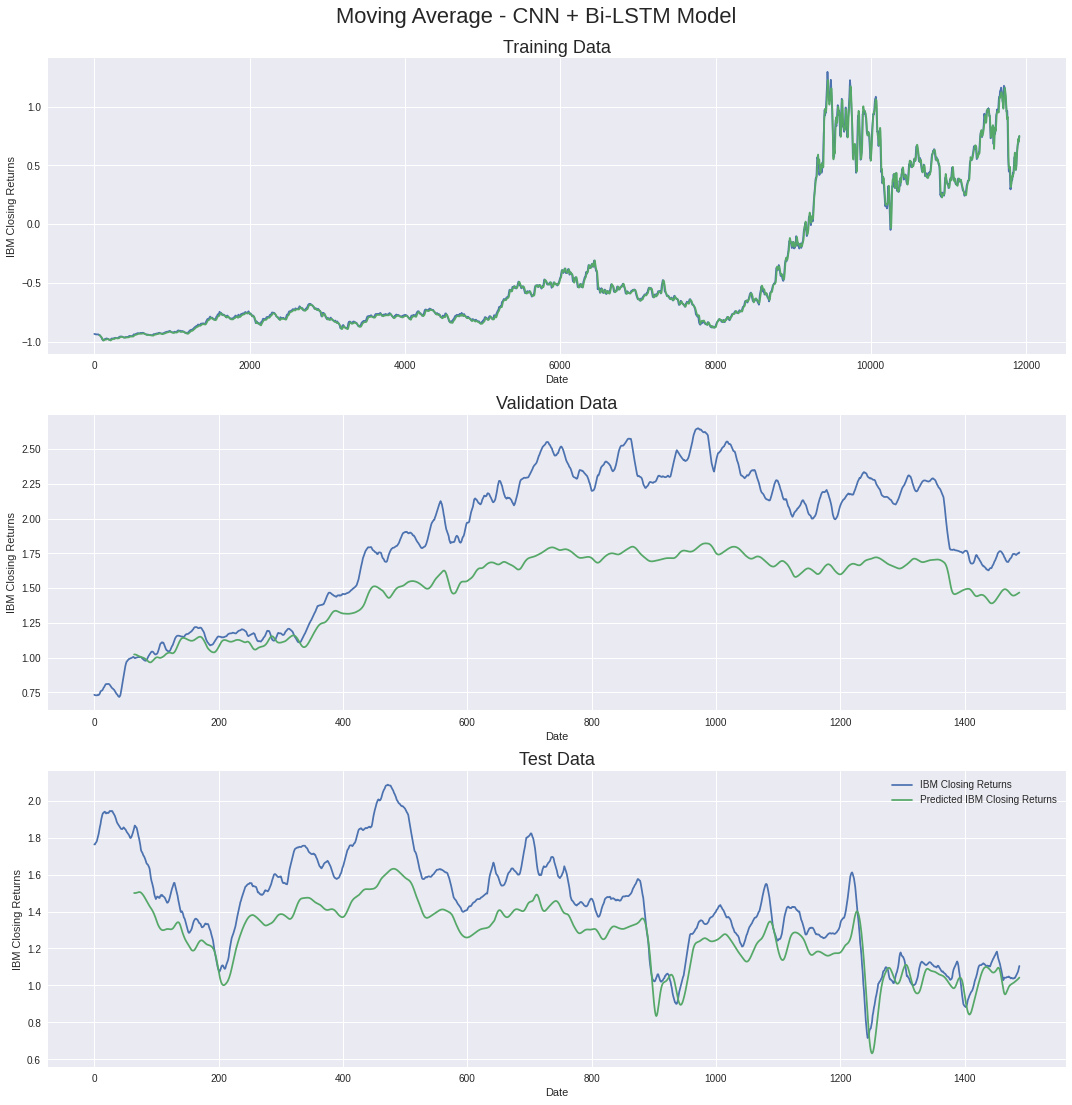

In [221]:
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len),train_pred, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len),val_pred, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

In [222]:
IBM_path = '/content/drive/MyDrive/coursework/test_IBM.csv'
exp = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
gr =  pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
# gr = gr[(gr.index >= 128)]
# Replace 0 to avoid dividing by 0 later on
exp['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
exp.sort_values('Date', inplace=True)
exp.tail()

exp.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values


###############################################################################
'''Normalize price columns'''
mean_close = np.mean(exp['Close'])
std_close = np.std(exp['Close'])
exp['Open'] = (exp['Open']-np.mean(exp['Open']))/np.std(exp['Open'])
exp['High'] = (exp['High']-np.mean(exp['High']))/np.std(exp['High'])
exp['Low'] = (exp['Low']-np.mean(exp['Low']))/np.std(exp['Low'])
exp['Close'] = (exp['Close']-np.mean(exp['Close']))/np.std(exp['Close'])
exp['Volume'] = (exp['Volume']-np.mean(exp['Volume']))/np.std(exp['Volume'])

exp.drop(columns=['Date'], inplace=True)
exp_test2 = exp #[(exp.index >= 127)]

# Convert pandas columns into arrays
exp_test2 = exp_test2.values
print(exp_test2.shape)
X_test2, y_test2 = [], []
for i in range(seq_len, len(exp_test2)):
    X_test2.append(exp_test2[i-seq_len:i])
    y_test2.append(exp_test2[:, 3][i]) 
X_test2, y_test2 = np.array(X_test2), np.array(y_test2)

print(X_test2.shape)

(252, 5)
(188, 64, 5)


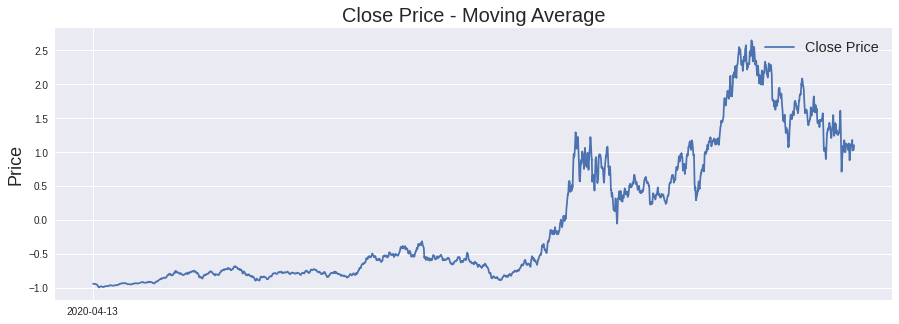

In [223]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, gr.shape[0], 1464), gr['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

In [224]:
test_pred2 = model.predict(X_test2)
# print(model.predict(X_test2))
o2 = model.predict(X_test2)*(std_close)+mean_close
# print(o2)
print(test_pred2.shape)
print(test_pred2[0][0],' ',y_test2[0])

(188, 1)
-0.92354554   -0.5258773361892655


188


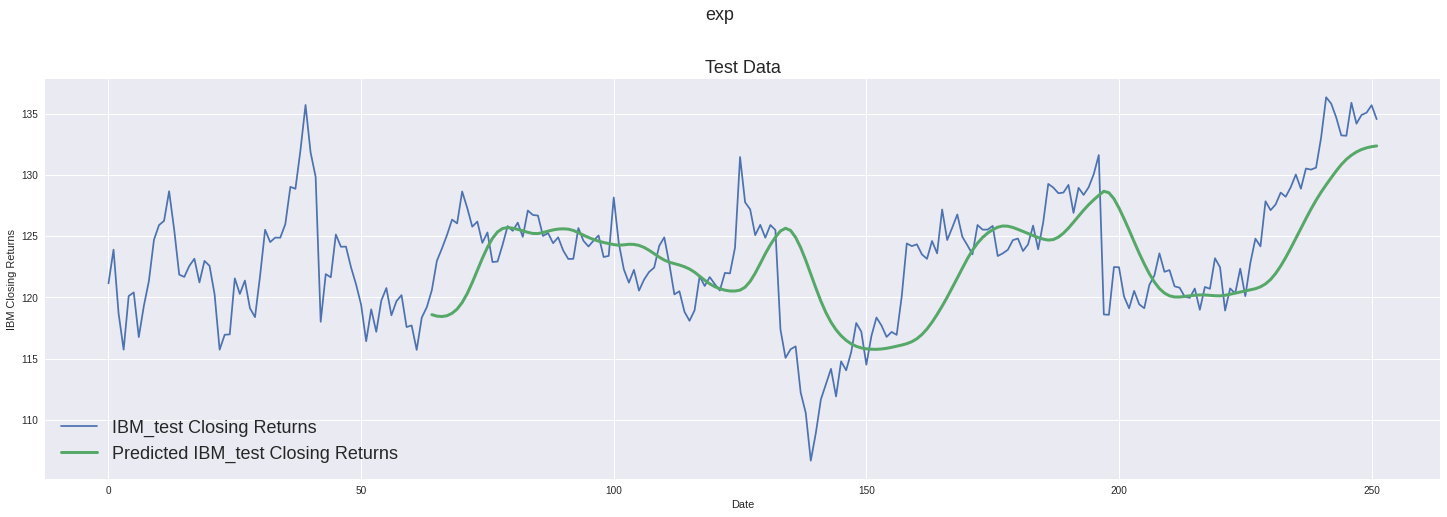

In [225]:
fig = plt.figure(figsize=(25,25))
# print(len(test_pred2))
print(len(y_test2))
st = fig.suptitle("exp", fontsize=18)
st.set_y(0.92)
ax41 = fig.add_subplot(311)
ax41.plot(gr['Close'], label='IBM_test Closing Returns')
# np.arange(seq_len, test_pred2.shape[0]+seq_len),
ax41.plot(np.arange(seq_len, test_pred2.shape[0]+seq_len), o2, linewidth=3, label='Predicted IBM_test Closing Returns')
ax41.set_title("Test Data", fontsize=18)
ax41.set_xlabel('Date')
ax41.set_ylabel('IBM Closing Returns')
ax41.legend(loc="best", fontsize=18)